In [13]:
import pandas as pd
import sklearn 
import scipy
from sklearn import linear_model as lm
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold, cross_val_score, StratifiedKFold, LabelKFold, ShuffleSplit
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt 
% matplotlib inline
import numpy as np
import math 
from mhcflurry import peptide_encoding, amino_acid
import statsmodels.api as sm
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, merge, Convolution1D, AveragePooling1D, Activation, Flatten
from keras.preprocessing import sequence
from keras.models import Model
from keras.engine import topology
import seaborn as sns

In [14]:
df = pd.read_table("bdata.2009.mhci.public.1.txt")
df_h = df[df['mhc']=='HLA-A-0201'][['sequence','meas']]
df_h['log_meas']=1-np.log(df_h['meas'])/math.log(50000)
max_len=df_h['sequence'].str.len().max()
n_peptides = df_h['sequence'].count()
from mhcflurry.amino_acid import common_amino_acids
def amino_acid_encoding(s, maxlen):
    a = 1+common_amino_acids.index_encoding([s],len(s)).flatten()
    return np.concatenate([a, np.zeros(maxlen-len(a),dtype=int)])
df_h['encoded_peptides'] = df_h.sequence.apply(lambda seq: amino_acid_encoding(seq, max_len))
df_h['peptide_length'] = df_h['sequence'].str.len()
df_h_9 = df_h[df_h['peptide_length']==9]
df_9 = df_h_9.reindex(np.random.permutation(df_h_9.index))
df_9.head(10)

,sequence,meas,log_meas,encoded_peptides,peptide_length
15526,ETIEILRNY,20000.000000,0.084687,"[4, 17, 8, 4, 8, 10, 15, 12, 20, 0, 0, 0, 0, 0...",9
19438,RTFHIFYYL,1.000000,1.000000,"[15, 17, 5, 7, 8, 5, 20, 20, 10, 0, 0, 0, 0, 0...",9
16885,ILFDRLPIA,1.000000,1.000000,"[8, 10, 5, 3, 15, 10, 13, 8, 1, 0, 0, 0, 0, 0, 0]",9
19905,SQLPPACPV,31.000000,0.682619,"[16, 14, 10, 13, 13, 1, 2, 13, 18, 0, 0, 0, 0,...",9
19805,SLTSINVQA,503.000000,0.425072,"[16, 10, 17, 16, 8, 12, 18, 14, 1, 0, 0, 0, 0,...",9
19278,RLVDYRKSV,1721.035340,0.311383,"[15, 10, 18, 3, 20, 15, 9, 16, 18, 0, 0, 0, 0,...",9
14653,ALMTLDDLA,67.403122,0.610834,"[1, 10, 11, 17, 10, 3, 3, 10, 1, 0, 0, 0, 0, 0...",9
16914,ILKPRIDKT,69444.444444,-0.030361,"[8, 10, 9, 13, 15, 8, 3, 9, 17, 0, 0, 0, 0, 0, 0]",9
17025,IPRRNVATL,78125.000000,-0.041247,"[8, 13, 15, 15, 12, 18, 1, 17, 10, 0, 0, 0, 0,...",9
19580,SDVTNRLEI,5565.640290,0.202907,"[16, 3, 18, 17, 12, 15, 10, 4, 8, 0, 0, 0, 0, ...",9


In [15]:
def measured_affinity_less_than(Y,k):
    IC50 = 50000**(1-Y)
    return (IC50 < k).astype(int) 

In [16]:
def affinity_label(Y):
    return measured_affinity_less_than(Y,50) + measured_affinity_less_than(Y,500) + measured_affinity_less_than(Y,5000) + measured_affinity_less_than(Y,50000) 

In [17]:
df_9['affinity_label'] = affinity_label(df_all['log_meas'])
df_9.head(10)

,sequence,meas,log_meas,encoded_peptides,peptide_length,affinity_label
15526,ETIEILRNY,20000.000000,0.084687,"[4, 17, 8, 4, 8, 10, 15, 12, 20, 0, 0, 0, 0, 0...",9,1
19438,RTFHIFYYL,1.000000,1.000000,"[15, 17, 5, 7, 8, 5, 20, 20, 10, 0, 0, 0, 0, 0...",9,4
16885,ILFDRLPIA,1.000000,1.000000,"[8, 10, 5, 3, 15, 10, 13, 8, 1, 0, 0, 0, 0, 0, 0]",9,4
19905,SQLPPACPV,31.000000,0.682619,"[16, 14, 10, 13, 13, 1, 2, 13, 18, 0, 0, 0, 0,...",9,4
19805,SLTSINVQA,503.000000,0.425072,"[16, 10, 17, 16, 8, 12, 18, 14, 1, 0, 0, 0, 0,...",9,2
19278,RLVDYRKSV,1721.035340,0.311383,"[15, 10, 18, 3, 20, 15, 9, 16, 18, 0, 0, 0, 0,...",9,2
14653,ALMTLDDLA,67.403122,0.610834,"[1, 10, 11, 17, 10, 3, 3, 10, 1, 0, 0, 0, 0, 0...",9,3
16914,ILKPRIDKT,69444.444444,-0.030361,"[8, 10, 9, 13, 15, 8, 3, 9, 17, 0, 0, 0, 0, 0, 0]",9,0
17025,IPRRNVATL,78125.000000,-0.041247,"[8, 13, 15, 15, 12, 18, 1, 17, 10, 0, 0, 0, 0,...",9,0
19580,SDVTNRLEI,5565.640290,0.202907,"[16, 3, 18, 17, 12, 15, 10, 4, 8, 0, 0, 0, 0, ...",9,1


In [18]:
X = pd.DataFrame(list(df_9['encoded_peptides'])).values
y = pd.DataFrame(list(df_9['log_meas'])).values

In [19]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y)

# Linear Regression 

[[  0   9 230   0   0]
 [  0  33 669   0   0]
 [  0   9 209   0   0]
 [  0   4 245   0   0]
 [  0   9 321   3   0]]


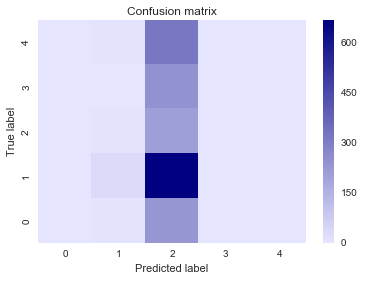

In [20]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)
print(confusion_matrix(affinity_label(y_test),affinity_label(lr_pred)))
blu = sns.light_palette("navy", as_cmap= True)
sns.heatmap(confusion_matrix(affinity_label(y_test),affinity_label(lr_pred)),cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

[[1159    0]
 [ 579    3]]


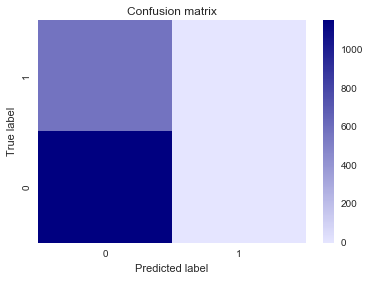

In [21]:
print(confusion_matrix(measured_affinity_less_than(y_test,500),measured_affinity_less_than(lr_pred,500)))
sns.heatmap(confusion_matrix(measured_affinity_less_than(y_test,500),measured_affinity_less_than(lr_pred,500)),cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

## SVM

[[  0   9 230   0   0]
 [  0  33 669   0   0]
 [  0   9 209   0   0]
 [  0   4 245   0   0]
 [  0   9 321   3   0]]


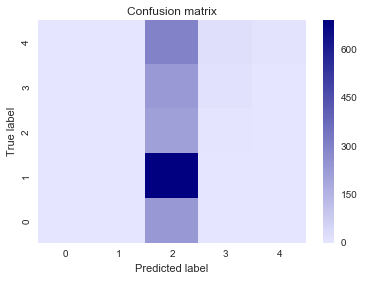

In [32]:
svm = SVR()
svm.fit(X_train,y_train[:,0])
svm_pred = svm.predict(X_test)
print(confusion_matrix(affinity_label(y_test),affinity_label(lr_pred)))
blu = sns.light_palette("navy", as_cmap= True)
sns.heatmap(confusion_matrix(affinity_label(y_test),affinity_label(svm_pred)),cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

[[1147   12]
 [ 536   46]]


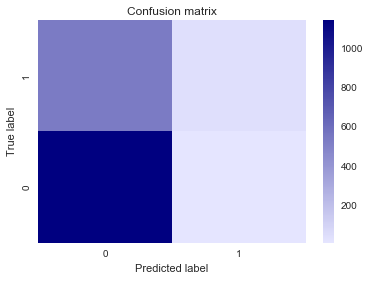

In [33]:
print(confusion_matrix(measured_affinity_less_than(y_test,500),measured_affinity_less_than(svm_pred,500)))
sns.heatmap(confusion_matrix(measured_affinity_less_than(y_test,500),measured_affinity_less_than(svm_pred,500)),cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

## GradientBoostingDescent

[[ 38 156  41   4   0]
 [ 72 437 161  30   2]
 [  1  46  97  72   2]
 [  0  17  76 129  27]
 [  0   2  41 147 143]]


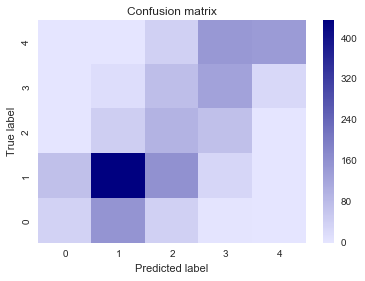

In [30]:
gbr = GradientBoostingRegressor(max_depth = 7)
gbr.fit(X_train,y_train[:,0])
gbr_pred = gbr.predict(X_test)
print(confusion_matrix(affinity_label(y_test),affinity_label(gbr_pred)))
blu = sns.light_palette("navy", as_cmap= True)
sns.heatmap(confusion_matrix(affinity_label(y_test),affinity_label(gbr_pred)),cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()

[[1049  110]
 [ 136  446]]


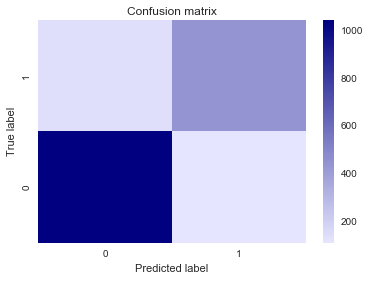

In [31]:
print(confusion_matrix(measured_affinity_less_than(y_test,500),measured_affinity_less_than(gbr_pred,500)))
sns.heatmap(confusion_matrix(measured_affinity_less_than(y_test,500),measured_affinity_less_than(gbr_pred,500)),cmap= blu, fmt="%d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix")
plt.gca().invert_yaxis()